# Lensing reconstruction tutorial

Primary Authors: Mathew Madhavacheril, Alexander van Engelen

V2 additions: Jeff McMahon

In [133]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
# We use some stuff we learned before
from cmb_modules import *
import lens_modules as lm
np.random.seed(100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this tutorial, we will learn how to obtain the underlying lensing convergence -- the projected (dark) matter density -- from an observed map of the CMB. 

We will first simulate a lensed CMB map as we learnt in an earlier tutorial

In [287]:
patch_deg_width = 40. # patch width in degrees
pix_size = 1.5 # pixel size in arcminutes
ells,ucltt,lcltt,clkk = lm.get_theory()
N,lensed,kappa,ly,lx,modlmap = lm.get_lensed(patch_deg_width,pix_size,ells,ucltt,clkk)

Let us now convolve this map with a beam and add noise

map mean: -11.76904646217382 map rms: 101.86358564689928


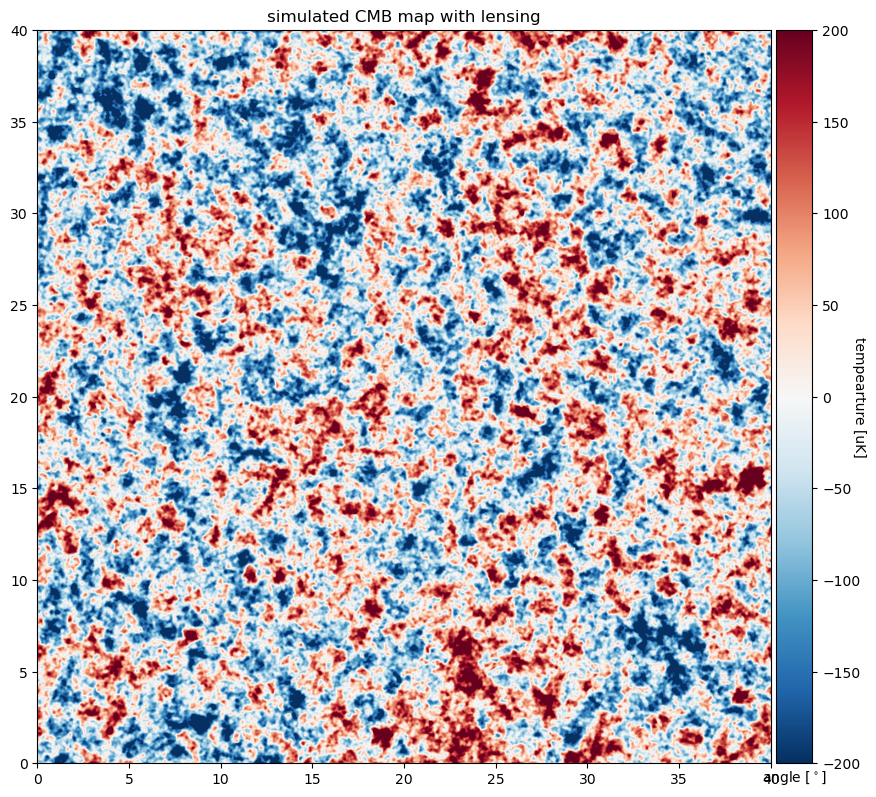

0

In [329]:
# Beam
beam_arcmin = 1.4
def gauss_beam(ell,fwhm):
    # A gaussian beam transfer function (map-space, i.e. one power)
    tht_fwhm = np.deg2rad(fwhm / 60.)
    return np.exp(-(tht_fwhm**2.)*(ell**2.) / (16.*np.log(2.)))
# Evaluate the beam on an isotropic Fourier grid
kbeam2d = gauss_beam(modlmap,beam_arcmin)
# Filter the map to convolve it with a beam
beamed = lm.filter_map(lensed,kbeam2d)

# Noise
noise_uk_arcmin = 3. 
# White noise
Clnoise = (noise_uk_arcmin*np.pi/180./60.)**2.
Dlnoise = Clnoise*ells*(ells+1.)/2./np.pi
# Make a GRF noise map
noise_map = make_CMB_T_map(N,pix_size,ells,Dlnoise)

# The observed map
observed = beamed + noise_map

plt.title("simulated CMB map with lensing")
Plot_CMB_Map(observed,-200,200,patch_deg_width,patch_deg_width)
             


## Lensing reconstruction

Let's expand the lens equation

$\newcommand{\al}{\boldsymbol{\alpha}}$
$\newcommand{\x}{\boldsymbol{x}}$
$\newcommand{\nab}{\boldsymbol{\nabla}}$
$\newcommand{\uT}{{\tilde{T}}}$
$\newcommand{\uC}{{\tilde{C}}}$
$\newcommand{\dphi}{{\nab\phi}}$
$\newcommand{\O}{{\mathcal{O}}}$
$\newcommand{\l}{{\boldsymbol{\ell}}}$
$\newcommand{\L}{{\boldsymbol{L}}}$
$$T(\x) = \uT(\x+\al)$$

in a Taylor series (and substitute $\al=\dphi$) in the weak-lensing limit of small $\phi$,

$$
T(\x) \approx \uT(\x) + \nabla \uT \cdot \dphi + \O(\dphi^2)
$$ 

 Homework excercise: Using 2d Fourier transforms,

$$
X(\l) = \int d^2\x ~e^{-i\l\cdot\x}X(\x)
$$
$$
X(\x) = \int \frac{d^2\l}{(2\pi)^2} ~e^{i\l\cdot\x}X(\l)
$$
$$
\int d^2\x e^{i\l\cdot\x} = (2\pi)^2 \delta(\l)
$$

show that to leading order in the lensing potential, lensing induces coupling between modes of the CMB map:


$$
\langle T(\l_1)T(\l_2) \rangle_{\rm CMB} = \phi(\L)\left[\uC^{TT}_{\ell_1}(\L \cdot \l_1) + \uC^{TT}_{\ell_2}(\L \cdot \l_2)\right]
$$

where the averaging is over realizations of the unlensed CMB field $\uT$.  Note: $L = \ell_2 - \ell_1$ represtnts the multiplole moment of the lensing reconstruciton.  

The correlations present in the above result motivates extracting modes of the lensing potential $\phi(\L)$ by taking a weighted average of products of CMB modes. The weights can be derived such that the noise in the reconstruction is minimized. The resulting estimator is:

$$
\hat{\kappa}(\L) = -A(\L) \int d^2\l_1 \left[\uC^{TT}_{\ell_1}(\L \cdot \l_1) + \uC^{TT}_{\ell_2}(\L \cdot \l_2)\right]\frac{T(\l_1)T(\l_2)}{C^{TT}_{\ell_1}C^{TT}_{\ell_2}}
$$

Homework excercise: Show that the above estimator can be written as a real-space multiplication

$$
\hat{\kappa} \propto -\nabla \cdot \left[\left(\nabla T_W\right) T_H \right]
$$

where $T_W$ is the temperature map Wiener filtered by $\frac{\uC^{TT}_{\ell}}{C^{TT}_{\ell}}$ and $T_H$ is the temperature map inverse variance filtered by $\frac{1}{C^{TT}_{\ell}}$.

In what follows we use this real space expression to recontruct an estimate for the lensing map and explore some of the issues that must be taclked to extraxt science from these maps.   

We refer you to the classic paper by [Hu and Okamoto](https://arxiv.org/pdf/astro-ph/0111606), and to a recent paper [Maniyar et al](https://arxiv.org/pdf/2101.12193) for more details of these quadratic estimators.  Maximum Liklihood techniques for lensign reconstruciton are know to produce higher signal to noise for the same experiment.  These are beyond the scope of this notebook.  If you are interested in details we recomend the classic paper by [Hirata and Seljak](https://arxiv.org/pdf/astro-ph/0209489) and the more recent paper by [Raghunathan et al](https://iopscience.iop.org/article/10.1088/1475-7516/2017/08/030/pdf)

### Excercise:
Code up the real space estimate given above to complete the lensing estimator that has been started for you below.


map mean: -5.659472890329198e-16 map rms: 46.73665648691913


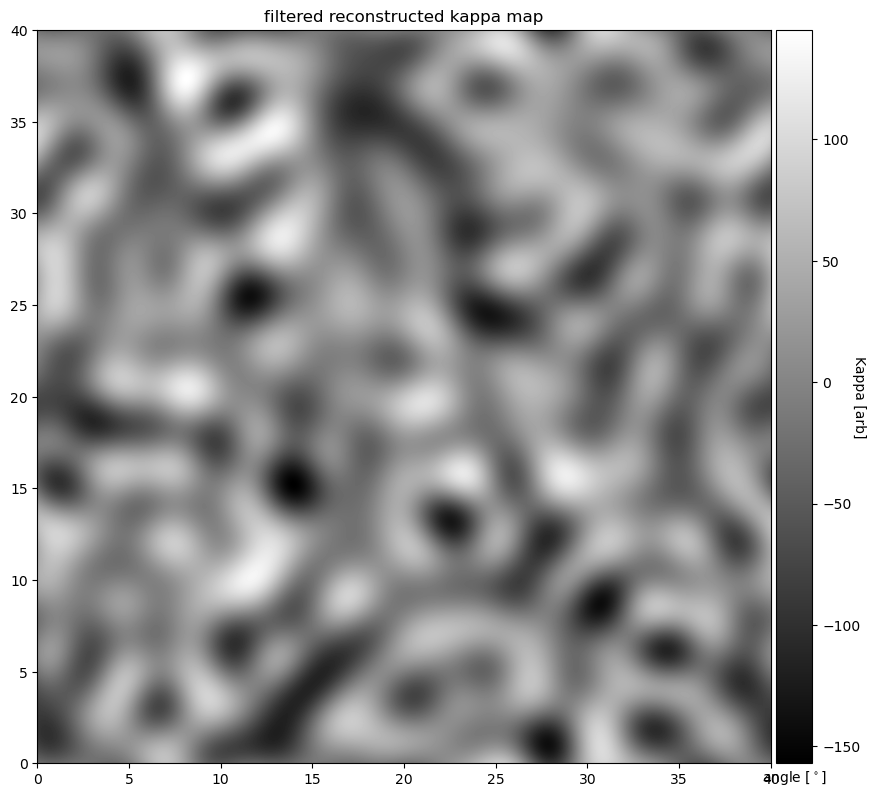

map mean: -1.1275702593849246e-19 map rms: 0.01159368472335847


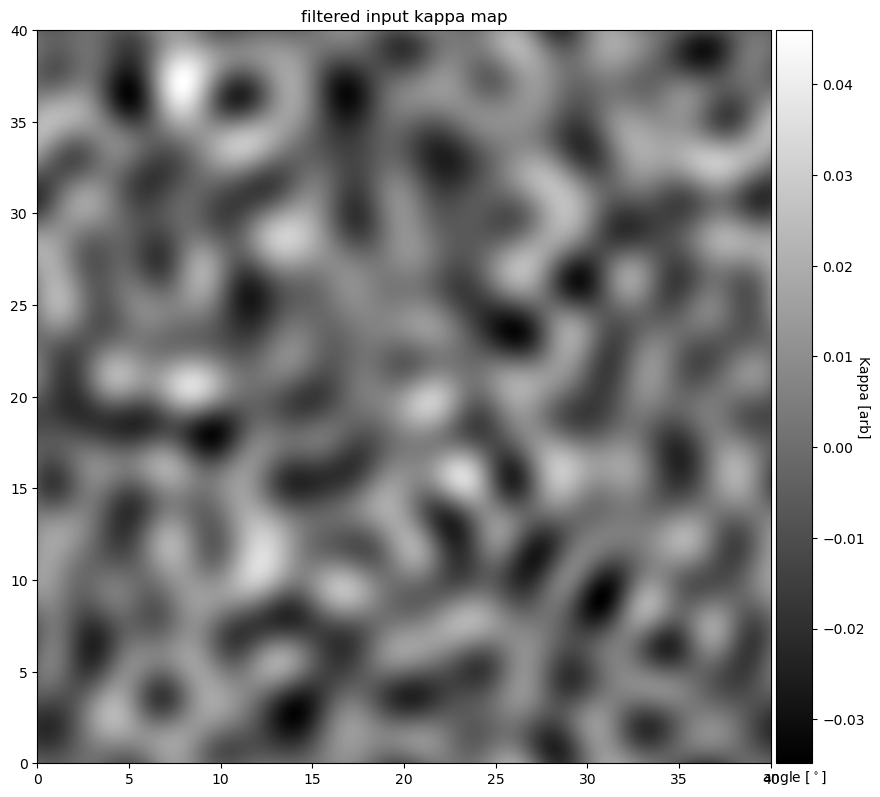

0

In [400]:
# Now we attempt to reconstruct a lensing map from the observed map
def qe_reconstruct(tmap,unlensed_cmb_power_2d,total_cmb_power_2d,ellmin,ellmax,modlmap,ly,lx):
    """
    The simplest form of the quadratic estimator is

    kappa_recon = - div ( grad(T) T )
    where grad(T) is Wiener filtered with (unlensed_cmb_power/total_cmb_power)
    and T is filtered with (1/total_cmb_power)
    where the T map is beam deconvolved and
    where total_cmb_power = lensed_cmb_power + noise_power / beam^2

    The reconstruction is limited to ellmin < ells < ellmax of the CMB temperature map.

    The grad and div operations require knowledge of:
    modlmap: absolute wavenumbers of Fourier pixels
    ly: map of ly Fourier coordinate of each pixel
    lx: map of lx Fourier coordinate of each pixel
    (note modlmap = sqrt(ly**2 + lx**2)
    """
    inv_noise_filter = lm.kmask((1./total_cmb_power_2d),modlmap,ellmin,ellmax)
    grad_filter = lm.kmask((unlensed_cmb_power_2d/total_cmb_power_2d),modlmap,ellmin,ellmax)

    gradTy,gradTx = lm.gradient(tmap,ly,lx)

    # The Wiener filtered gradient Grad(T_G)
    filtered_gradTy = lm.filter_map(gradTy,grad_filter)
    filtered_gradTx = lm.filter_map(gradTx,grad_filter)
    # The inverse variance filtered T_H
    filtered_T = lm.filter_map(tmap,inv_noise_filter)
    
    ############## COMPLETE THIS!!!
    # ADD A LINE BELOW TO GET ukappa = divergence(Grad(T_G) * T_H)



    
    ############## COMPLETE THIS!!!
    
    # We filter with 1/L^2 at the end to make the normalization white
    return -lm.filter_map(ukappa,lm.kmask(1/modlmap**2,modlmap,ellmin=2))

# For this we also need to know how to calculate a divergence
def div(imapy,imapx,ly,lx):
    # Return divergence grad(Y)_y + grad(X)_x
    ############## COMPLETE THIS!!!
    # COMPLETE THIS FUNCTION THAT RETURNS THE DIVERGENCE
    ############## COMPLETE THIS!!!
    return divergence


def interp(x,y,bounds_error=False,fill_value=0.,**kwargs):
    # Just a simple interpolator that fills with zeros by default
    from scipy.interpolate import interp1d
    return interp1d(x,y,bounds_error=bounds_error,fill_value=fill_value,**kwargs)


# To use this we need unlensed and total spectra interpolated on to the 2D Fourier grid
### Prepare 2D Fourier space interpolations of theory spectra
unlensed_cmb_power_2d = interp(ells,ucltt)(modlmap)
total_cmb_power_2d = interp(ells,lcltt)(modlmap) + Clnoise/kbeam2d**2.


### The noise was specified for a beam deconvolved map so we deconvolve the beam from our map
tmap = lm.filter_map(observed,1/kbeam2d)

### Next, we get the unnormalized reconstruction after choosing what multipoles to involve
ellmin = 100
ellmax = 3000
ukappa = qe_reconstruct(tmap,unlensed_cmb_power_2d,total_cmb_power_2d,ellmin,ellmax,modlmap,ly,lx)
# Calculating the normalization is a bit involved, so for now we focus on comparing
# the largest scales of the reconstruction with that of the input, where the normalization is
# expected to be somewhat constant

### Filter the reconstruction and the input kappa to the same ellrange (where the normalization
### is expected to be relatively white)
kellmin = 10
kellmax = 100
ukappa_f = lm.filter_map(ukappa,lm.kmask(modlmap*0.+1.,modlmap,kellmin,kellmax))
ikappa_f = lm.filter_map(kappa,lm.kmask(modlmap*0.+1.,modlmap,kellmin,kellmax))

# Plot the filtered maps for comparison

plt.title("filtered reconstructed kappa map")
Plot_CMB_Lensing_Map(ukappa_f,patch_deg_width,patch_deg_width)
             
plt.title("filtered input kappa map")
Plot_CMB_Lensing_Map(ikappa_f,patch_deg_width,patch_deg_width)
         


You should be able to see a correspondence of peaks and valleys by eye in the above reconstruction if you have implemented it correctly.  Note- we have not computed the nomrmalization yet.   We will compare the input to recostructed map in two ways.  First using linear algebra to project out the common component, and secondly we will cross-correlate the reconstruction with the input and compare this to the input power spectrum. 


## compare the input and reconstructed maps

Since the normalization of the reconstructed lensing map is arbitrary a simple difference between these maps will not provide a reasonable estimate of the residuals.  One must estimate the relative normalization to make this comparison.   Here we show a widely applicable trick from linear algera that is handy in a wide range of related circumstances.   

If we treat the input map as a vector we can use methods from linear algebra to estimate the normalization and then make the comparison. This amoubts to the following steps:

1. Compute a unit vector aligned with the input map $\vec I$ to a unit vector, $ \hat I = \frac {\vec I} {\sqrt{|| \vec I}||}$
1. Compute the coefficent that fully removes the input map from the reconstructed map $\eta= \vec I \cdot \vec R$, where $\vec R$ is the reconstructed map
1. Use this coefficient to remove the input map from the reconstructed map to produce a noise map $\vec N = \vec R - \eta \hat I$

The code that follows carries this out.

In [ ]:
## remove the input map from the reconstructed map -- put your code here.  The first step is done for you.

unit_i = ikappa_f / (np.sum(ikappa_f*ikappa_f))**.5
eta = 
independat_part = 

plt.title("reconstructed minus input map")
Plot_CMB_Lensing_Map(independat_part,patch_deg_width,patch_deg_width)
         
## 

### Excercise / Discussion Questions--

Discuss how well this method removed these signals.  
1. How well did the reconstruction reproduce the input?

1. What might cause these residuals?  How can you check?
1. Did we make any choices in this analysis? If so, which could affect this?
1. What realworld features of a true observing campaign could lead to additional biases?  If we have time, try implementing one of more of these to see what they do.


## cross-spectra

EXERCISE: This looks good by eye! But are we sure it's not just a coincidence? The systematic way of checking that your lensing pipeline is working is to cross-correlate your reconstruction with the input kappa you provided. Calculate the binned 1d cross power and confirm it is non-zero and compare it to theory.  

Below is code that can be addapted to carry out this cross-correlation.  It was pasted from the CMB power spectrum module. 

In [ ]:
### Calculate binned 1d cross-power between reconstruction and input
ell_max = 1000
delta_ell = 10

##
Normalize_by_hand = 1

## make a cross-power spectrum
binned_ell, binned_spectrum = calculate_2d_spectrum(,,delta_ell,ell_max,pix_size,N)
#print binned_ell
plt.semilogy(binned_ell,binned_spectrum* binned_ell * (binned_ell+1.)/2. / np.pi / Normalize_by_hand)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$L$')

## reload the thoery
ells,ucltt,lcltt,clkk = lm.get_theory()
DlKK = clkk*ells*(ells+1.)/2./np.pi

plt.semilogy(ells,DlKK)
plt.xlim(0,ell_max)
plt.ylim(1e-6,1)
plt.show()

 


### Excercise and Discussion

1. adjust the nomarlization to make the curves line up.
1. how well does the shape of the two curves match up?
   -A- Really well.
1. What expalins the abrupt cuttoff in the cross-correlation at $\ell - 100$?
  -A- its the filtering of te output maps, have them change it to ell = 1000.  the maps will look terrible, but the spectrum great. see below
1. Adjust the filtering so that the reconstruiton extends to $\ell = 1000$. How well do these curves agree? You may have to adjust the normalization.  How do the maps look when you go up to this fine scale?
     -A- this will look good in the power spectrum, but terrible in the map.   Disucss this in class.
1. Play wiht the high and low $\ell$ limits for the reconstruciton and see hwo the angular scales and disucss what happens. 

Unforuntatly in real life we do not know the true lensing signal.   We can compute cross-correlations between CMB lensing estimators and other tracers of large scale strucure like galaxy weak lensing, or the galaxy density estimated from visable or infrared photometric surveys.  However, these tracers include their own biases.   This provices measuermnts of a broad range of astrophysical paramters and cross-checks on cosmology and thus represnts a major research effort for the field. See the [DES 6x2 Analysis](https://arxiv.org/pdf/2206.10824) for example.


## auto spectra 
Harvisting the full information content of CMB lensing requries dealing with these biases, but enables use of the CMB lensing autocorrelaiton.     In what follows we explore some of the issues that must be tackled to go beyond cross-correlation measumrnts.  

### Excercise: 
  Modify the code you wrote above to compute the auto-correaltion.   Then ansewere the discusison quesitons below.  You should adjust the filting so you can see modes up to $L = 1000$

In [ ]:
Normalize_by_hand = 1000

## make a auto-power spectrum
binned_ell, binned_spectrum = calculate_2d_spectrum(,,delta_ell,ell_max,pix_size,N)
#print binned_ell
plt.semilogy(binned_ell,binned_spectrum* binned_ell * (binned_ell+1.)/2. / np.pi / Normalize_by_hand**2)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$L$')

## reload the thoery
ells,ucltt,lcltt,clkk = lm.get_theory()
DlKK = clkk*ells*(ells+1.)/2./np.pi

plt.semilogy(ells,DlKK)
plt.xlim(0,ell_max)
plt.ylim(1e-6,1)
plt.show()

### Excercise / Discussion questions

1. Is there bias in this estimator?  How could you differentiate noise vs bias?
1. What could affect the bias you see here?   Can you test abd confirm this?


## Bias In Lensing Estimators 

Dealing with bias in estimtes of the lensign power spectrum represts a large body of continuing research.   Major types of Biases include:

1.   $N^{(0)}$ bias is the expectation value of the lensing power spectrum estimator that would be obtained if the CMB were an unlensed Gaussian field that had the power spectrum of the observed lensed CMB. 
1. $N^{(1)}$ bias arises from the correlations between gaussian noise and the reconstructed lensing map.
1. $N^{(2)}$ bias arises from the correlations between non-gaussian noise and the reconstructed lensing map.

Contributions to these biases can arrise from the noise properties of the instruemnt, instrumental such as systematics including beam assymetries, galactic foregrounds, ectra galacitc sources including AGN and SZ sources especially when correlated with large scale strucutres, and effects from masking portions of the galaxy or sources to remove foregorunds signals.    

These effects can be mitigated through carful choice of estimators (bias hardened estimators, and cross-estimators) or removed through monte-carlo simulations.   These biases can be large, so dealing with these represntst the primary area of effort for prodcing cosmology from CMB lensing.  As the data go deeper, the required percisions for mitigating these effects must necissarly grow.   

### Excercise:

choose and model one systematic effect.    Foregound masking and the inclusion of astrophysical sources are two easy opitons.